In [14]:
from psaw import PushshiftAPI
import datetime as dt
import json
import requests 
import networkx as nx
import time
import datetime

In [50]:
# Global variables
api = PushshiftAPI()
comment_ids_endpoint_url = 'https://api.pushshift.io/reddit/submission/comment_ids/'
comment_endpoint_url = 'https://api.pushshift.io/reddit/comment/search/'
submission_endpoint_url = 'https://api.pushshift.io/reddit/submission/search/'
start_epoch=int(dt.datetime(2017, 11, 1).timestamp())
end_epoch=int(dt.datetime(2018, 1, 30).timestamp())

In [51]:
start_time = time.time()
print("Starting at " + str(datetime.datetime.now()))

cascade = nx.DiGraph()
sub_counter = 0

submission_url = submission_endpoint_url + "?subreddit=" + 'bitcoin' \
            + "&after=" + str(start_epoch) + "&before=" + str(end_epoch) \
            + "&fields=selftext,title,num_comments,created,created_utc,retrieved_on,score,full_link,media,url,subreddit,subreddit_id"

with open("cascades.txt", "w") as f:
    
    sub_r = requests.get(url = submission_url)
    print("Submission URL:", submission_url)
    
    if sub_r.status_code == 200:
        sub_json_obj = json.loads(sub_r.text)
        sub_arr = sub_json_obj['data']

    for s in sub_arr:

        sub_id = s['id']
        cascade.add_node(sub_id, created_utc=s['created_utc'], type='s')
        f.write(str(s) + '\n')

        sub_counter += 1
        if sub_counter % 1000 == 0:
            print("Adding ", sub_counter, "th submission")

        comment_ids_url = comment_ids_endpoint_url + str(sub_id)
        r = requests.get(url = comment_ids_url)

        if r.status_code == 200:
            comment_ids_json_obj = json.loads(r.text)
            comment_ids_arr = comment_ids_json_obj['data']
            
            if len(comment_ids_arr) > 0 :                
                comment_ids_str = ','.join(comment_ids_arr)

                comment_url = comment_endpoint_url + "?ids=" + comment_ids_str \
                + "&size=" + str(10) \
                + "&fields=id,author,body,created,created_utc,retrieved_on,score,parent_id,link_id,subreddit,subreddit_id"

                com_r = requests.get(url = comment_url)
                if com_r.status_code == 200:
                    comment_json_obj = json.loads(com_r.text)
                    comment_ids_arr = comment_json_obj['data']

                    c_counter = 0
                    for c in comment_ids_arr:
                        cascade.add_node(c['id'], created_utc=c['created_utc'], type='c')
                        cascade.add_edge(c['id'], c['parent_id'][3:])
                        f.write(str(c) + '\n')
                        c_counter += 1

                        if c_counter % 1000 == 0:
                            print("Adding ",c_counter, "th comment to ", sub_counter, "th submission")            


print("Finished at " + str(datetime.datetime.now()))
print("Total time: --- {0} seconds ---".format(round(time.time() - start_time, 4)))

Starting at 2019-09-30 11:46:48.814058
Submission URL: https://api.pushshift.io/reddit/submission/search/?subreddit=bitcoin&after=1509508800&before=1517288400&fields=id,author,title,num_comments,created,created_utc,retrieved_on,score,full_link,media,url,subreddit,subreddit_id
Finished at 2019-09-30 11:47:36.029887
Total time: --- 47.2165 seconds ---


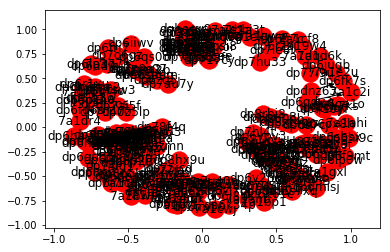

In [52]:
pos = nx.spring_layout(cascade)
nx.draw_networkx(cascade, pos)

In [53]:
len(cascade.edges)

173

In [54]:
len(cascade.nodes)

227

In [55]:
cascade.nodes.data()

NodeDataView({'7a19w4': {'created_utc': 1509508843, 'type': 's'}, '7a1a3t': {'created_utc': 1509508903, 'type': 's'}, '7a1ahi': {'created_utc': 1509509036, 'type': 's'}, 'dp6ox8h': {'created_utc': 1509538671, 'type': 'c'}, 'dp6s7cj': {'created_utc': 1509543561, 'type': 'c'}, 'dp6s7xq': {'created_utc': 1509543583, 'type': 'c'}, 'dp6n1mj': {}, 'dp6sbsx': {'created_utc': 1509543726, 'type': 'c'}, 'dp6hi9c': {}, 'dp7040z': {'created_utc': 1509552392, 'type': 'c'}, 'dp6fd6s': {}, 'dp705lp': {'created_utc': 1509552437, 'type': 'c'}, 'dp8bt90': {'created_utc': 1509611107, 'type': 'c'}, 'dp8kt4p': {'created_utc': 1509629864, 'type': 'c'}, 'dp8p0hb': {'created_utc': 1509634672, 'type': 'c'}, 'dp8prm3': {'created_utc': 1509635462, 'type': 'c'}, 'dp8rbi8': {'created_utc': 1509637043, 'type': 'c'}, '7a1anb': {'created_utc': 1509509097, 'type': 's'}, '7a1bbj': {'created_utc': 1509509339, 'type': 's'}, '7a1bp1': {'created_utc': 1509509446, 'type': 's'}, '7a1bt1': {'created_utc': 1509509481, 'type': 

In [56]:
cascade.nodes['7a19w4']['created_utc']

1509508843

In [57]:
for n in nx.neighbors(cascade, 'dbcvs1'):
    print(n, cascade.nodes[n])

NetworkXError: The node dbcvs1 is not in the digraph.

In [58]:
cascade['dp6ox8h']

AtlasView({'7a1ahi': {}})

In [59]:
for n in cascade.neighbors('f206k14'):
    print(n)

NetworkXError: The node f206k14 is not in the digraph.

In [60]:
nx.write_edgelist(cascade,'cascades.edgelist',data=['created_utc'])

In [61]:
nx.write_edgelist(cascade,'cascades_1.edgelist')

In [62]:
components = list(nx.weakly_connected_components(cascade))

print("Found", len(components), "cascades")

for i, c in enumerate(components) :
    c_subgraph = cascade.subgraph(c)
    
    root_post_id, root_epoch = None, 0
    
    for (node, val) in c_subgraph.out_degree():
        if val == 0 and 'type' in c_subgraph.nodes[node] and c_subgraph.nodes[node]['type'] == 's':
            root_post_id = node
            break
    
    if root_post_id is None:
        continue
        
    print("Found root: ", root_post_id)
    if 'created_utc' in c_subgraph.nodes[root_post_id]:
        root_epoch = int(c_subgraph.nodes[root_post_id]['created_utc'])
    
    first_c, first_c_epoch = None, 1517288400
    
    for n in c_subgraph.predecessors(root_post_id):
    #for n in c_subgraph.neighbors(root_post_id) :
        if 'created_utc' in c_subgraph.nodes[n]:
            epoch = int(c_subgraph.nodes[n]['created_utc'])
        if epoch < first_c_epoch:
            first_c, first_c_epoch = n, epoch
            
    print(i+1, "th cascade; root node:", root_post_id, root_epoch,
         "First comment:", first_c, first_c_epoch, "Initial delay:", first_c_epoch - root_epoch)
        

Found 54 cascades
Found root:  7a19w4
1 th cascade; root node: 7a19w4 1509508843 First comment: None 1517288400 Initial delay: 7779557
Found root:  7a1a3t
2 th cascade; root node: 7a1a3t 1509508903 First comment: None 1517288400 Initial delay: 7779497
Found root:  7a1ahi
3 th cascade; root node: 7a1ahi 1509509036 First comment: dp6ox8h 1509538671 Initial delay: 29635
Found root:  7a1anb
7 th cascade; root node: 7a1anb 1509509097 First comment: None 1517288400 Initial delay: 7779303
Found root:  7a1bbj
8 th cascade; root node: 7a1bbj 1509509339 First comment: None 1517288400 Initial delay: 7779061
Found root:  7a1bp1
9 th cascade; root node: 7a1bp1 1509509446 First comment: None 1517288400 Initial delay: 7778954
Found root:  7a1bt1
10 th cascade; root node: 7a1bt1 1509509481 First comment: dp6oukc 1509538539 Initial delay: 29058
Found root:  7a1bwl
18 th cascade; root node: 7a1bwl 1509509509 First comment: None 1517288400 Initial delay: 7778891
Found root:  7a1c2i
19 th cascade; root no

In [ ]:
## Comment Using wrapper


#         comments = api.search_comments(subreddit='bitcoin', 
#                                        ids = comment_ids_str,
#                                        after=start_epoch,
#                                        before=end_epoch,
#                                        filter=['id', 'author', 'body', 
#                                                'created', 'created_utc', 'retrieved_on', 
#                                                'score', 'parent_id', 'link_id'])
#         print("Recievced comments")
#         cs = list(comments)
#         print(len(cs))
#         c_counter = 0
#         for c in cs:
#             print(c.id, c.author, c.score, c.parent_id)
#             # The first three characters of the parent_id are t[1-5]_ which indicate the type of the parent 
#             cascade.add_node(c.id, created_utc=c.created_utc)
#             cascade.add_edge(c.id, c.parent_id[3:])
#             c_counter += 1
            
#             if c_counter % 100 == 0:
#                 print("Adding ",c_counter, "th comment to ", sub_counter, "th submission")

In [ ]:
# submission Using wrapper

# subs = api.search_submissions(limit=20,
#                              subreddit='bitcoin',
#                              after=start_epoch,
#                              before=end_epoch,
#                              filter=['id', 'author', 'title', 'num_comments', 'created',
#                                      'created_utc', 'retrieved_on', 'full_link', 'media', 'score', 'url']
#                             )